# Нейронная сеть прямого распространения для задачи классификации

## Загрузка и подготовка данных

Начнем с загрузки датасата с kaggle. Необходимо использовать свой .json файл, чтобы открыть канал для загрузки, а также скопировать текст api команды. Ниже приводится стандартный код для загрузки датасета с kaggle.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseimedvedev","key":"e7e2e8ad9f177293686bb5c420c22c41"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d datamunge/overheadmnist

100% 218M/218M [00:11<00:00, 26.5MB/s]
100% 218M/218M [00:11<00:00, 20.2MB/s]


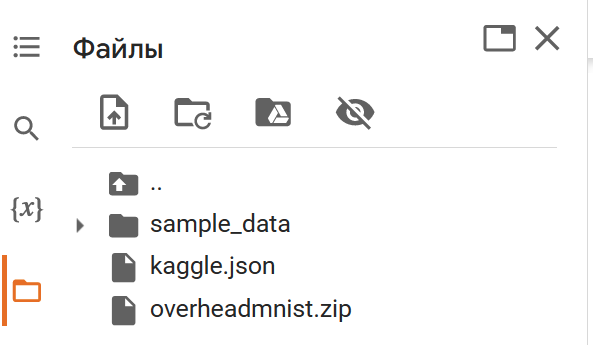

Архив скачался на внутреннюю память среды colab. Давайте его разархивируем.

In [5]:
from IPython.core.display import clear_output
!unzip '/content/overheadmnist.zip' -d '/content/overheadmnist'
clear_output()

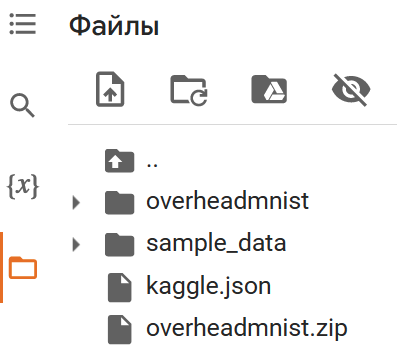

Создаем torch датасеты с помощью класса ImageFolder.

In [6]:
datadir='/content/overheadmnist/overhead'
traindir = datadir + '/training/'
testdir = datadir + '/testing/'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cuda'

In [9]:
train_transform = T.Compose([T.Resize((28,28)),T.Grayscale(), T.ToTensor()])
test_transform = T.Compose([T.Resize((28,28)),T.Grayscale(),T.ToTensor()])

In [10]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=test_transform)

Зададим два итератора данных, которые разобьют выборки на случайные пакеты фиксированного размера.

In [11]:
batch_size=128 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

In [12]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([128, 1, 28, 28])


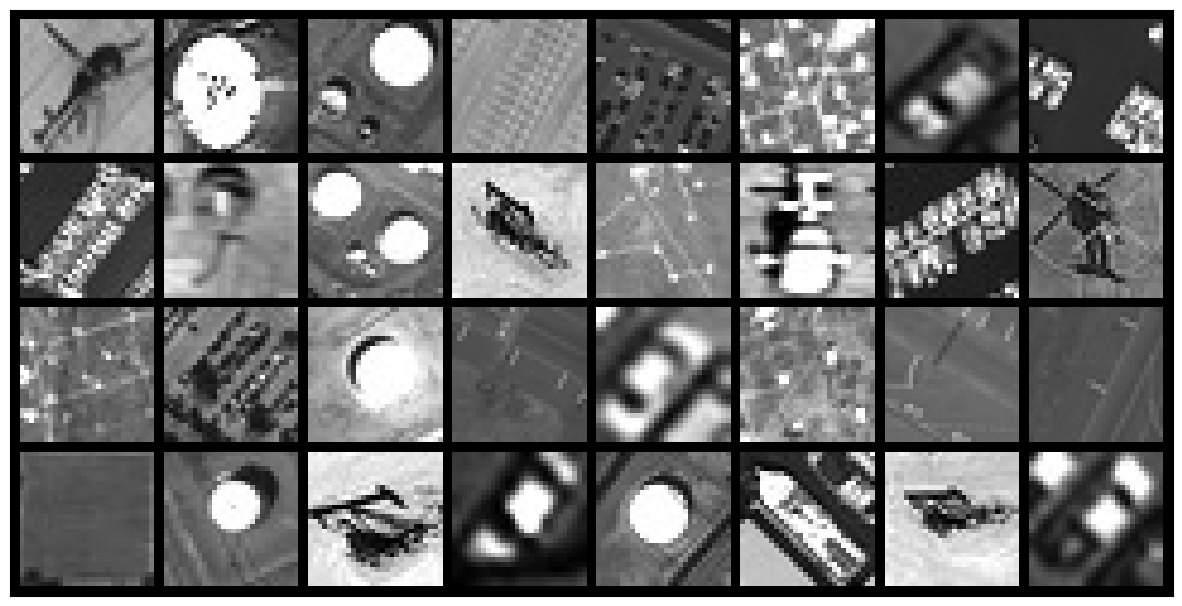

In [13]:
show_batch(dataloaders['train'])

## Задаем модель

In [14]:
import torch.nn as nn

class Simple_Overhead_MNIST_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,128)
    self.fc2 = nn.Linear(128,10)
    self.activation = nn.LeakyReLU(inplace=True)
    self.drop = nn.Dropout(0.5) # слой дропаута с вероятностью выключения нейрона 0.5

  def forward(self,x): # прямой проход модели
    x = x.view(-1,28*28) # распрямляем изображение в вектор
    x = self.fc1(x)
    x = self.drop(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

Инициализируем модель и отправляем на вычислительный процессор.

In [15]:
model=Simple_Overhead_MNIST_NN()
model.to(device)

Simple_Overhead_MNIST_NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  (drop): Dropout(p=0.5, inplace=False)
)

Выведем подробную детализацию модели.

In [16]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
from torchinfo import summary
summary(model,input_size=(1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Simple_Overhead_MNIST_NN                 [1, 10]                   --
├─Linear: 1-1                            [1, 128]                  100,480
├─Dropout: 1-2                           [1, 128]                  --
├─LeakyReLU: 1-3                         [1, 128]                  --
├─Linear: 1-4                            [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

## Цикл обучения модели.

Создаем цикл обучения модели.

In [18]:
! pip install livelossplot --quiet

In [19]:
from livelossplot import PlotLosses

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_model(model, criterion, optimizer, num_epochs=10):
  liveloss = PlotLosses()
  model = model.to(device)
  
  for epoch in range(num_epochs):
      logs = {}
      for phase in ['train', 'validation']: # две фазы: тренировочная и валидационная
          if phase == 'train':
              model.train() # режим тренировки - веса могут обновляться
          else:
              model.eval()  # режим валидации - веса заморожены

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs) # прямой проход модели
              loss = criterion(outputs, labels) # ошибка пакета

              if phase == 'train':
                  optimizer.zero_grad() # обнуляем градиенты
                  loss.backward()  # обратное распространение ошибки
                  optimizer.step() # обновление весов алгоритмом оптимизации

              _, preds = torch.max(outputs, 1) 
              running_loss += loss.detach() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
          
          prefix = ''
          if phase == 'validation':
              prefix = 'val_'

          logs[prefix + 'log loss'] = epoch_loss.item()
          logs[prefix + 'accuracy'] = epoch_acc.item()
      
      liveloss.update(logs)
      liveloss.send()

## Запуск обучения модели

In [20]:
model=Simple_Overhead_MNIST_NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

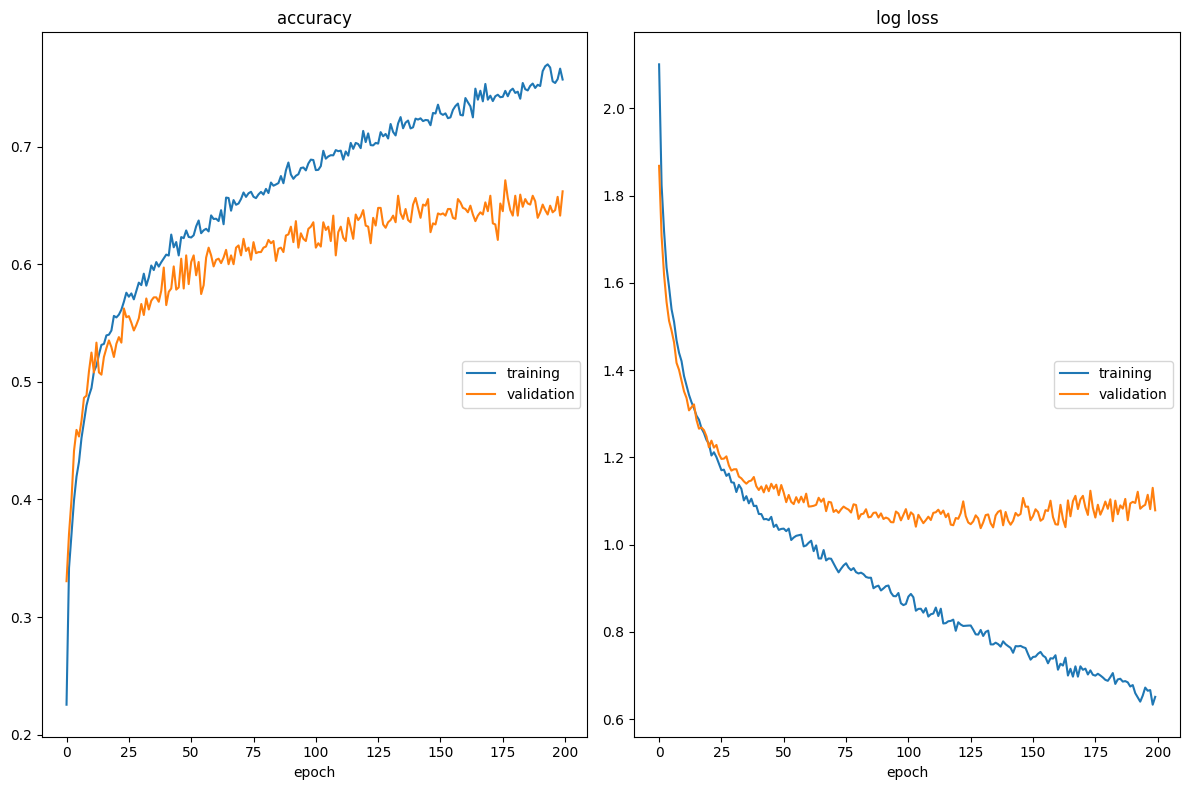

accuracy
	training         	 (min:    0.225, max:    0.770, cur:    0.757)
	validation       	 (min:    0.331, max:    0.671, cur:    0.662)
log loss
	training         	 (min:    0.633, max:    2.101, cur:    0.651)
	validation       	 (min:    1.038, max:    1.868, cur:    1.078)


In [21]:
train_model(model, criterion, optimizer, num_epochs=200)